In [8]:
import os
import json
import shutil
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from transformers import (
    AutoConfig,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoModel,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from bertviz import head_view
from transformers_interpret import SequenceClassificationExplainer
import zipfile
os.environ["WANDB_DISABLED"] = "true"

In [9]:
zip_file_path = '/Users/osama/Desktop/Imperial/ML in Healthcare/mlhc2025/notebook/final_clinicalbert_model (2).zip'
model_dir = './clinicalbert_triage_model'

# Unzip the archive
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(model_dir)

In [10]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load the tokenizer and model from the extracted folder
model_checkpoint = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_dir)

In [11]:
df = pd.read_csv("/Users/osama/Desktop/Imperial/ML in Healthcare/mlhc2025/notebook/MLHC_test_2ndApril.csv")

# Map triage levels to numerical labels
triage_mapping = {
    "Immediate.": 0,
    "Emergent.": 1,
    "Urgent.": 2,
    "Semi-urgent.": 3,
    "Nonurgent.": 4
}
df["triage_value"] = df["triage_level"].map(triage_mapping)

In [13]:
df = df[:200]
len(df)

200

In [14]:
# Count the number of occurrences for each triage value
counts = df["triage_value"].value_counts().sort_index()

print("Number of values per triage level:")
for triage_value, count in counts.items():
    print(f"Triage {triage_value + 1}: {count}")

Number of values per triage level:
Triage 1: 3
Triage 2: 32
Triage 3: 114
Triage 4: 46
Triage 5: 5


In [15]:
eval_texts = df["text_data"].tolist()
eval_labels = df["triage_value"].tolist()

# Tokenize the evaluation texts
max_length = 256
eval_encodings = tokenizer(eval_texts, padding="max_length", truncation=True, max_length=max_length)

# Create a custom dataset for evaluation
class TriageDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

eval_dataset = TriageDataset(eval_encodings, eval_labels)

In [16]:
# --------------------------
# Define a Minimal Trainer for Prediction
# --------------------------
training_args = TrainingArguments(
    output_dir='./results', 
    per_device_eval_batch_size=16, 
    evaluation_strategy="no"  # No evaluation during training; only using trainer for predict
)

trainer = Trainer(
    model=model,
    args=training_args,
)

/Users/osama/miniforge3/envs/tf_metal/lib/python3.9/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



--- Baseline Metrics ---
Accuracy: 0.6400
AUC (weighted, OvR): 0.7517
Underreporting: 41.67%
Overreporting: 58.33%
Mean Confidence: 0.6139


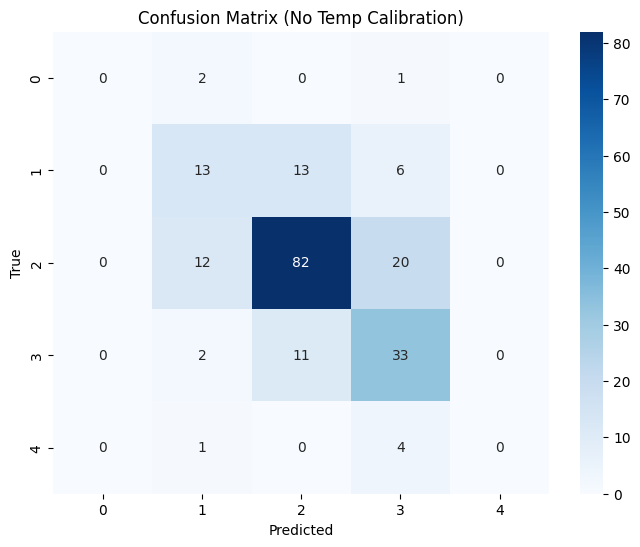

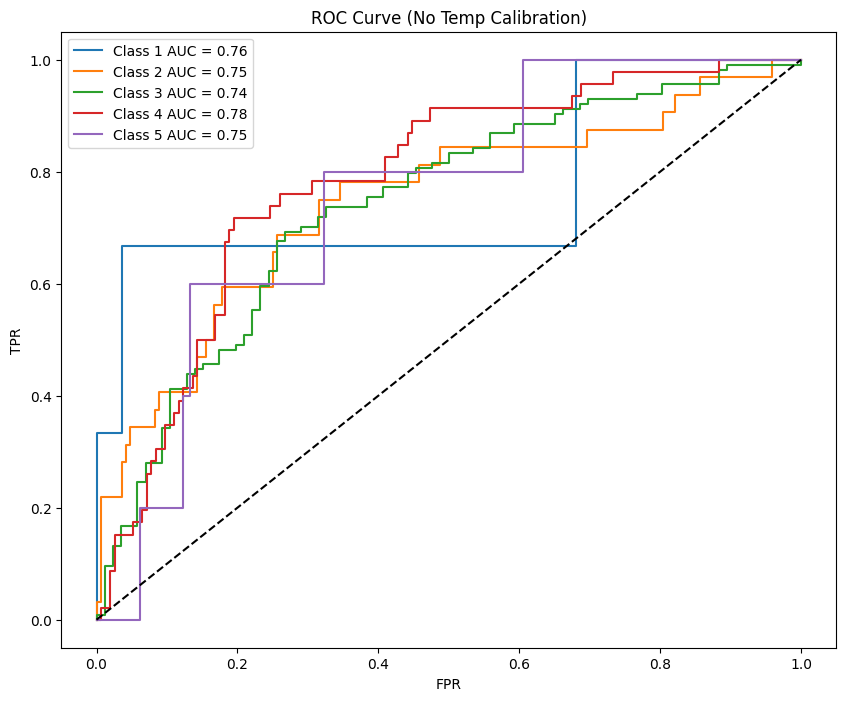

Temperature: 0.50, NLL: 1.1580
Temperature: 1.00, NLL: 0.9529
Temperature: 1.50, NLL: 0.9954
Temperature: 2.00, NLL: 1.0651
Temperature: 2.50, NLL: 1.1289

Optimal Temperature: 1.0 | NLL: 0.9529

--- Metrics with Temp Calibration ---
Accuracy: 0.6400
AUC (weighted, OvR): 0.7517
Mean Confidence: 0.6139


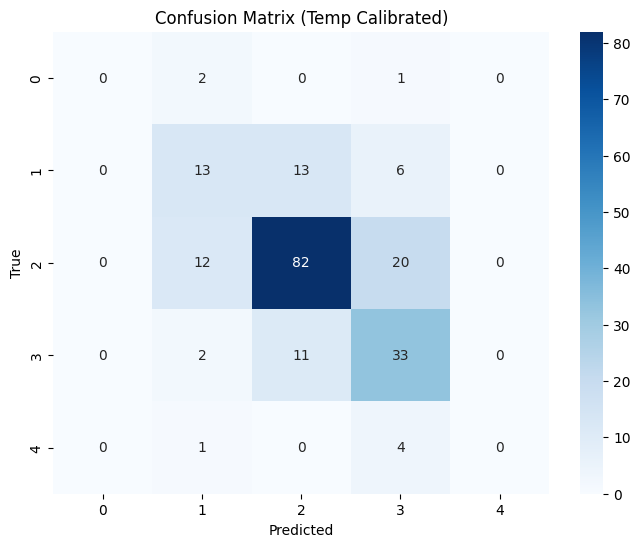

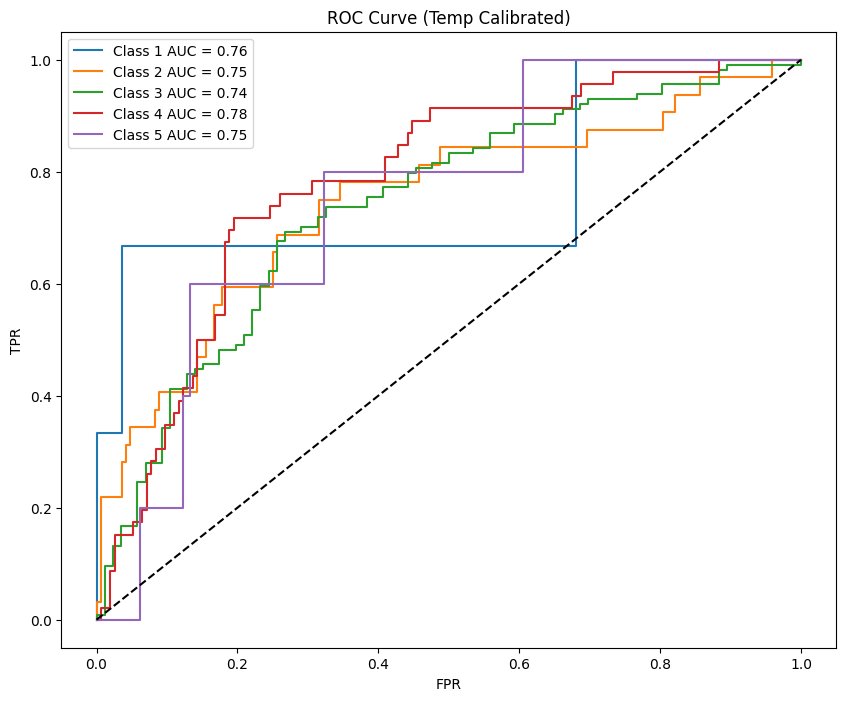


Mean Entropy (Calibrated): 0.9416


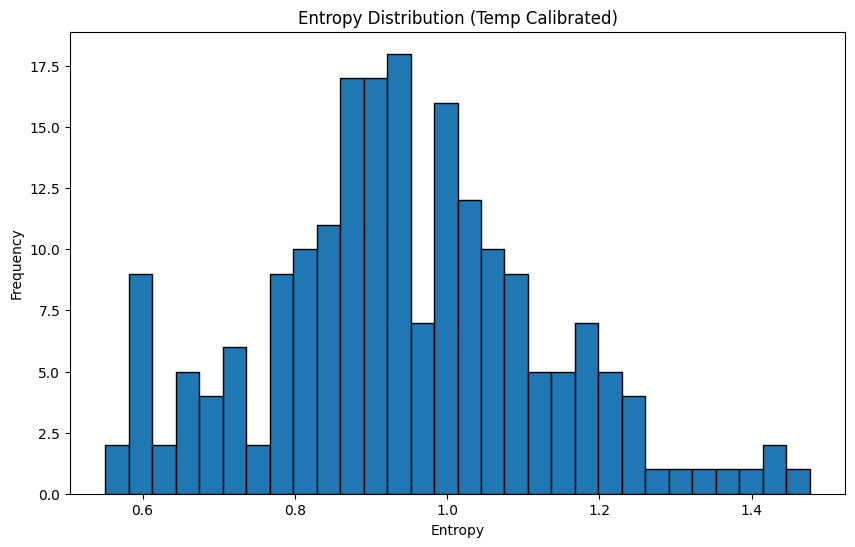

In [18]:
import os
import json
import shutil
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_auc_score, confusion_matrix,
    roc_curve, auc
)
from sklearn.preprocessing import label_binarize
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments
)
import zipfile
# -------------------------------
# Evaluation Functions
# -------------------------------

def apply_temperature(logits, temperature):
    return logits / temperature

def softmax_with_temperature(logits, temperature):
    scaled_logits = apply_temperature(logits, temperature)
    return F.softmax(scaled_logits, dim=1)

def negative_log_likelihood(probs, labels):
    labels = torch.tensor(labels)
    probs_tensor = torch.tensor(probs)
    correct_class_probs = probs_tensor[range(len(labels)), labels]
    nll = -torch.mean(torch.log(correct_class_probs + 1e-8))
    return nll.item()

def find_optimal_temperature(logits, labels, temperature_values):
    best_temp = None
    best_nll = float("inf")
    logits_tensor = torch.tensor(logits)
    for temp in temperature_values:
        probs_temp = softmax_with_temperature(logits_tensor, temp).detach().numpy()
        nll = negative_log_likelihood(probs_temp, labels)
        print(f"Temperature: {temp:.2f}, NLL: {nll:.4f}")
        if nll < best_nll:
            best_nll = nll
            best_temp = temp
    return best_temp, best_nll

def calculate_entropy(probabilities):
    epsilon = 1e-8
    return -np.sum(probabilities * np.log(probabilities + epsilon), axis=1)

# -------------------------------
# Run Evaluation (without temperature scaling)
# -------------------------------
preds_output = trainer.predict(eval_dataset)
logits = preds_output.predictions
labels = preds_output.label_ids

probs = F.softmax(torch.tensor(logits), dim=1).numpy()
preds = np.argmax(probs, axis=1)
accuracy = accuracy_score(labels, preds)

try:
    auc_value = roc_auc_score(labels, probs, multi_class="ovr", average="weighted")
except:
    auc_value = float("nan")

cm = confusion_matrix(labels, preds)
wrong_mask = preds != labels
if np.sum(wrong_mask) > 0:
    pct_underreport = np.mean(preds[wrong_mask] < labels[wrong_mask]) * 100
    pct_overreport  = np.mean(preds[wrong_mask] > labels[wrong_mask]) * 100
else:
    pct_underreport = pct_overreport = 0
mean_prob = np.mean(np.max(probs, axis=1))

print("\n--- Baseline Metrics ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC (weighted, OvR): {auc_value:.4f}")
print(f"Underreporting: {pct_underreport:.2f}%")
print(f"Overreporting: {pct_overreport:.2f}%")
print(f"Mean Confidence: {mean_prob:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (No Temp Calibration)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# --- ROC Curve (Without Temp Scaling) ---
n_classes = probs.shape[1]
labels_binarized = label_binarize(labels, classes=list(range(n_classes)))
fpr, tpr, roc_auc_dict = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(labels_binarized[:, i], probs[:, i])
    roc_auc_dict[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i+1} AUC = {roc_auc_dict[i]:.2f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve (No Temp Calibration)")
plt.legend()
plt.show()

# -------------------------------
# Temperature Scaling
# -------------------------------
temperature_values = [0.5, 1.0, 1.5, 2.0, 2.5]
optimal_temp, optimal_nll = find_optimal_temperature(logits, labels, temperature_values)
print(f"\nOptimal Temperature: {optimal_temp} | NLL: {optimal_nll:.4f}")

optimal_probs = softmax_with_temperature(torch.tensor(logits), optimal_temp).detach().numpy()
optimal_preds = np.argmax(optimal_probs, axis=1)

accuracy_opt = accuracy_score(labels, optimal_preds)
try:
    auc_opt = roc_auc_score(labels, optimal_probs, multi_class="ovr", average="weighted")
except:
    auc_opt = float("nan")

cm_opt = confusion_matrix(labels, optimal_preds)
mean_prob_opt = np.mean(np.max(optimal_probs, axis=1))

print("\n--- Metrics with Temp Calibration ---")
print(f"Accuracy: {accuracy_opt:.4f}")
print(f"AUC (weighted, OvR): {auc_opt:.4f}")
print(f"Mean Confidence: {mean_prob_opt:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(cm_opt, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Temp Calibrated)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# --- ROC Curve (After Temp Scaling) ---
labels_binarized_opt = label_binarize(labels, classes=list(range(n_classes)))
fpr_opt, tpr_opt, roc_auc_dict_opt = {}, {}, {}
for i in range(n_classes):
    fpr_opt[i], tpr_opt[i], _ = roc_curve(labels_binarized_opt[:, i], optimal_probs[:, i])
    roc_auc_dict_opt[i] = auc(fpr_opt[i], tpr_opt[i])

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr_opt[i], tpr_opt[i], label=f"Class {i+1} AUC = {roc_auc_dict_opt[i]:.2f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve (Temp Calibrated)")
plt.legend()
plt.show()

# -------------------------------
# Uncertainty (Entropy)
# -------------------------------
entropy_values = calculate_entropy(optimal_probs)
mean_entropy = np.mean(entropy_values)
print(f"\nMean Entropy (Calibrated): {mean_entropy:.4f}")

plt.figure(figsize=(10, 6))
plt.hist(entropy_values, bins=30, edgecolor='k')
plt.xlabel("Entropy")
plt.ylabel("Frequency")
plt.title("Entropy Distribution (Temp Calibrated)")
plt.show()